<a href="https://colab.research.google.com/github/mblackstock/notebooks/blob/main/crypto_data_api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crypto data analysis


In [1]:
import pandas as pd
import requests
from datetime import datetime

In [27]:
from_symbol = 'LTC'
to_symbol = 'USD'
exchange = 'Bitstamp'
datetime_interval = 'day'
data_path = '/content/drive/MyDrive/Colab Notebooks/data/crypto_data/'

In [10]:
def get_filename(from_symbol, to_symbol, exchange, datetime_interval, download_date):
    return '%s_%s_%s_%s_%s.csv' % (from_symbol, to_symbol, exchange, datetime_interval, download_date)

def download_data(from_symbol, to_symbol, exchange, datetime_interval):
    supported_intervals = {'minute', 'hour', 'day'}
    assert datetime_interval in supported_intervals,\
        'datetime_interval should be one of %s' % supported_intervals
    print('Downloading %s trading data for %s %s from %s' %
          (datetime_interval, from_symbol, to_symbol, exchange))
    base_url = 'https://min-api.cryptocompare.com/data/histo'
    url = '%s%s' % (base_url, datetime_interval)
    params = {'fsym': from_symbol, 'tsym': to_symbol,
              'limit': 2000, 'aggregate': 1,
              'e': exchange}
    request = requests.get(url, params=params)
    data = request.json()
    return data

def convert_to_dataframe(data):
    df = pd.json_normalize(data, ['Data'])
    df['datetime'] = pd.to_datetime(df.time, unit='s')
    df = df[['datetime', 'low', 'high', 'open',
             'close', 'volumefrom', 'volumeto']]
    return df

def filter_empty_datapoints(df):
    indices = df[df.sum(axis=1) == 0].index
    print('Filtering %d empty datapoints' % indices.shape[0])
    df = df.drop(indices)
    return df



In [14]:
data = download_data(from_symbol, to_symbol, exchange, datetime_interval)
df = convert_to_dataframe(data)
df = filter_empty_datapoints(df)
current_datetime = datetime.now().date().isoformat()
filename = get_filename(from_symbol, to_symbol, exchange, datetime_interval, current_datetime)
print('Saving data to %s' % filename)
df.to_csv(filename, index=False)

Filtering 558 empty datapoints
Saving data to LTC_USD_Bitstamp_day_2021-06-06.csv


In [28]:
def get_filename(from_symbol, to_symbol, exchange, datetime_interval, download_date):
    return '%s%s_%s_%s_%s_%s.csv' % (data_path, from_symbol, to_symbol, exchange, datetime_interval, download_date)

def read_dataset(filename):
    print('Reading data from %s' % filename)
    df = pd.read_csv(filename)
    df.datetime = pd.to_datetime(df.datetime) # change to datetime
    df = df.set_index('datetime') 
    df = df.sort_index() # sort by datetime
    print(df.shape)
    return df

In [29]:
df_btc = read_dataset(get_filename('BTC', 'USD', 'Bitstamp', 'day', '2021-06-06'))
df_eth = read_dataset(get_filename('ETH', 'USD', 'Bitstamp', 'day', '2021-06-06'))
df_ltc = read_dataset(get_filename('LTC', 'USD', 'Bitstamp', 'day', '2021-06-06'))

Reading data from /content/drive/MyDrive/Colab Notebooks/data/crypto_data/BTC_USD_Bitstamp_day_2021-06-06.csv
(2001, 6)
Reading data from /content/drive/MyDrive/Colab Notebooks/data/crypto_data/ETH_USD_Bitstamp_day_2021-06-06.csv
(1306, 6)
Reading data from /content/drive/MyDrive/Colab Notebooks/data/crypto_data/LTC_USD_Bitstamp_day_2021-06-06.csv
(1443, 6)


In [31]:
df_eth.head()

,low,high,open,close,volumefrom,volumeto
datetime,,,,,,
2017-11-09,317.29,331.70,322.15,321.32,13118.15,4270934.90
2017-11-10,291.00,325.61,321.32,298.66,34411.65,10580539.65
2017-11-11,298.00,322.19,298.66,315.76,23836.74,7328431.51
2017-11-12,300.11,318.98,315.76,306.10,48200.80,14854823.36
2017-11-13,305.91,320.69,306.10,316.14,36613.50,11517856.30


In [32]:
df = pd.DataFrame({'BTC': df_btc.close,
                   'ETH': df_eth.close,
                   'LTC': df_ltc.close})
df.tail()

,BTC,ETH,LTC
datetime,,,
2021-06-02,37589.36,2707.66,187.23
2021-06-03,39219.88,2856.41,193.23
2021-06-04,36887.32,2691.14,178.62
2021-06-05,35532.14,2629.40,172.78
2021-06-06,35551.62,2678.26,173.45


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2001 entries, 2015-12-15 to 2021-06-06
Freq: D
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BTC     2001 non-null   float64
 1   ETH     1306 non-null   float64
 2   LTC     1443 non-null   float64
dtypes: float64(3)
memory usage: 62.5 KB


Absolute price plot

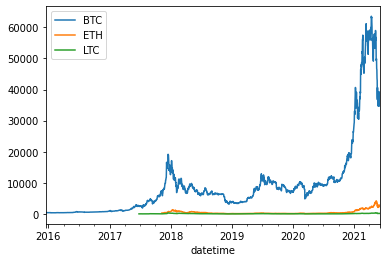

In [25]:
df.plot()

relative plot

We create an axis for each plot separately.

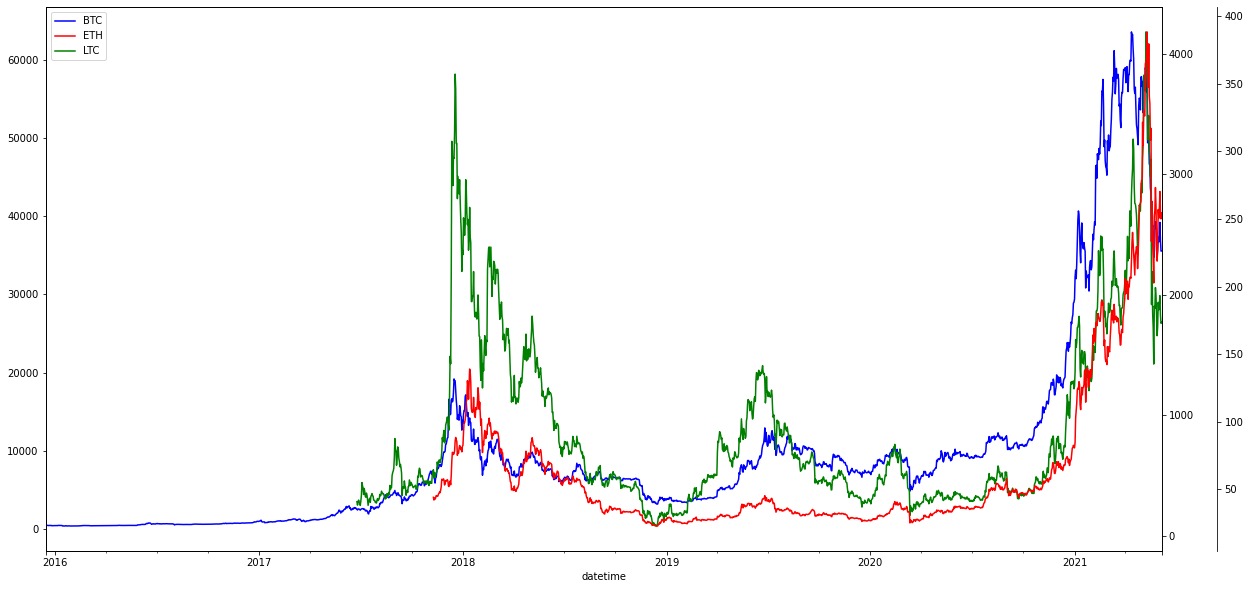

In [49]:
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# move this axis over to the right a bit - magic.
rspine = ax2.spines['right']
rspine.set_position(('axes', 1.05))

df['BTC'].plot(ax=ax1, style='b-')
df['ETH'].plot(ax=ax1, style='r-', secondary_y=True)  # use a secondary y-axis on the right
df['LTC'].plot(ax=ax2, style='g-')

# legend
ax2.legend([ax1.get_lines()[0],
            ax1.right_ax.get_lines()[0],
            ax2.get_lines()[0]],
           ['BTC', 'ETH', 'LTC'])

# References

* https://towardsdatascience.com/cryptocurrency-analysis-with-python-buy-and-hold-c3b0bc164ffa

* https://towardsdatascience.com/cryptocurrency-analysis-with-python-macd-452ceb251d7c
